# Explore data variance

## Setup

In [1]:
sample_file <- "sample_combined_2019-09-16.feather"

In [2]:
library(DataAnalysisTools)
library(tidyverse)
library(oildata)

── Attaching packages ──────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ─────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
set.seed(6)

## Load data

In [4]:
sample <- feather::read_feather(sample_file)
sample_n(sample, 5)

YEAR,OPERATOR_ID,CRUDE_AGE_UNKNOWN_MILES,CRUDE_AVG_AGE,CRUDE_INCIDENTS,CRUDE_MILES,CRUDE_MILES_1940,CRUDE_MILES_1950,CRUDE_MILES_1960,CRUDE_MILES_1970,⋯,HVL_MILES_2000_3,HVL_MILES_2010_3,NON_HVL_MILES_1940_3,NON_HVL_MILES_1950_3,NON_HVL_MILES_1960_3,NON_HVL_MILES_1970_3,NON_HVL_MILES_1980_3,NON_HVL_MILES_1990_3,NON_HVL_MILES_2000_3,NON_HVL_MILES_2010_3
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,26049,0,31.3655,1,2.2,45.8,8.8,0,27.2,⋯,0.00,0.00,0,151.30,0.20,0.00,52.70,0.20,1.40,0.60
2011,ONEOK (Group),0,0.0000,0,0.0,0.0,0.0,0,0.0,⋯,4705.96,183.28,0,443.19,326.37,116.70,71.94,29.19,0.26,0.45
2005,4805,0,0.0000,0,0.0,0.0,0.0,0,0.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2006,25146,0,0.0000,0,0.0,0.0,0.0,0,0.0,⋯,9.10,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011,Chevron (Group),0,0.0000,0,0.0,0.0,0.0,0,0.0,⋯,154.69,0.00,170,1753.45,673.12,97.09,57.32,0.00,38.35,0.00


In [5]:
data(pipelines_2010)
sample_n(pipelines_2010, 5)

DATAFILE_AS_OF,Year,REPORT_NUMBER,SUPPLEMENTAL_NUMBER,ID,Name,PARTA4STREET,PARTA4CITY,PARTA4STATE,PARTA4ZIP,⋯,PARTE2010HF,PARTE2010LF,PARTE2010TOTAL,PARTETOTAL,PARTETOTALHF,PARTETOTALLF,REPORT_SUBMISSION_TYPE,REPORT_DATE,FILING_DATE,FORM_REV
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<dttm>,<chr>
2019-12-02 04:43:41,2011,20120304,12435,26085,Plains Marketing,"333 Clay Street, Suite 1600",CUSHING,TX,77002,⋯,0.00,0,0.00,90.54,90.54,0.00,SUPPLEMENTAL,2012-06-14 11:20:23,2013-08-08 10:59:43,7000-1.1 (Rev. 06-2011)
2019-12-02 05:24:44,2017,20183341,15868,39566,Lucid Energy Delaware,3100 MCKINNON ST. SUITE 800,DALLAS,TX,75201,⋯,27.60,0,27.60,27.60,27.60,0.00,INITIAL,2018-06-12 10:59:52,2018-06-12 10:59:52,7000-1.1 (Rev. 06-2014)
2019-12-02 05:12:02,2016,20172781,15159,30544,Occidental Chemical,5005 LBJ FREEWAY STE 2200,Dallas,TX,75244-6119,⋯,0.00,0,0.00,0.00,0.00,0.00,INITIAL,2017-06-14 11:16:26,2017-06-14 11:16:26,7000-1.1 (Rev. 06-2014)
2019-12-02 05:02:31,2014,20151639,13789,2731,Chevron Pipe Line,4800 FOURNACE PLACE RM C388,BELLAIRE,TX,77401-2324,⋯,1.60,0,1.60,143.70,61.50,82.20,INITIAL,2015-06-15 16:58:27,2015-06-15 16:58:27,7000-1.1 (Rev. 06-2014)
2019-12-02 04:54:18,2013,20141053,13113,32109,Oneok Ngl Pipeline,100 WEST FIFTH STREET,TULSA,OK,74102,⋯,911.77,0,911.77,7201.52,6110.13,1091.39,SUPPLEMENTAL,2014-06-15 21:56:42,2014-06-17 13:22:07,7000-1.1 (Rev. 06-2011)


## Add missing names

In [6]:
sample$Name <- oildata::add_company_names(sample$OPERATOR_ID)
head(sample)

YEAR,OPERATOR_ID,CRUDE_AGE_UNKNOWN_MILES,CRUDE_AVG_AGE,CRUDE_INCIDENTS,CRUDE_MILES,CRUDE_MILES_1940,CRUDE_MILES_1950,CRUDE_MILES_1960,CRUDE_MILES_1970,⋯,HVL_MILES_2010_3,NON_HVL_MILES_1940_3,NON_HVL_MILES_1950_3,NON_HVL_MILES_1960_3,NON_HVL_MILES_1970_3,NON_HVL_MILES_1980_3,NON_HVL_MILES_1990_3,NON_HVL_MILES_2000_3,NON_HVL_MILES_2010_3,Name
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2015,1248,0,38.58750,1,64.000,0,0.000,359.000,149.00,⋯,0.00,0.00,0.000,147.000,0.000,0.000,80.00,0.000,0.000,Belle Fourche Pipeline
2015,14194,0,0.00000,0,0.000,0,0.000,0.000,0.00,⋯,0.00,0.00,0.000,0.000,0.000,0.000,16.74,28.940,0.000,"Oiltanking, Houston"
2015,15156,0,38.54918,0,211.000,79,10.000,168.000,113.00,⋯,0.00,49.00,12.000,600.000,179.000,3.000,138.00,188.000,114.000,Sinclair Transportation Company
2015,19319,0,0.00000,0,0.000,0,0.000,0.000,0.00,⋯,0.00,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,Tpc Group
2015,22430,0,59.68541,0,3.582,0,3.554,0.023,0.00,⋯,0.00,0.00,63.152,755.763,150.046,9.894,9.74,0.672,0.983,West Shore Pipeline
2015,22855,0,29.24262,1,798.900,0,213.880,0.000,264.61,⋯,36.53,5.59,0.630,29.790,4.260,2478.960,1096.80,13.740,2.530,"Flint Hills Resources, Lc"


## Grab largest companies

### Largest operators by total miles

In [7]:
largest_companies <- sample %>%
    group_by(Name) %>%
    filter(TOTAL_MILES == max(TOTAL_MILES)) %>%
    ungroup() %>%
    mutate(Name = fct_reorder(Name, TOTAL_MILES)) %>%
    arrange(desc(TOTAL_MILES)) %>%
    select(Name, TOTAL_MILES)

head(largest_companies) %>%
    jupyter_styling(font_size = 16)

Name,TOTAL_MILES
Enterprise Products Operating,13401.76
ONEOK (Group),10784.50
Phillips 66 (Group),10356.00
Magellan (Group),9162.00
Kinder Morgan (Group),7976.34
NuStar (Group),7228.80


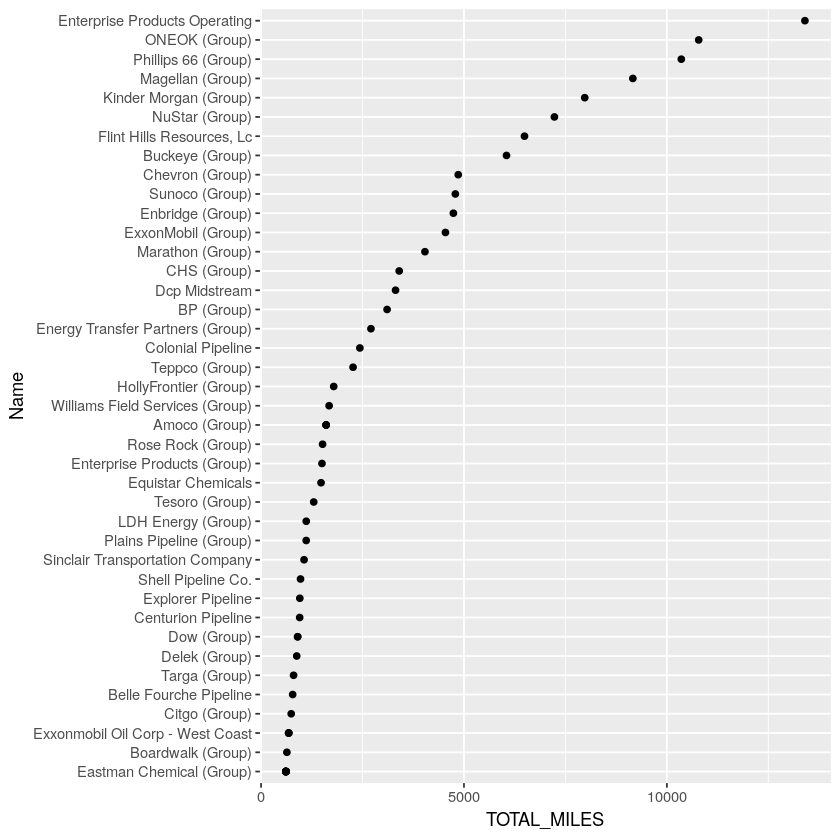

In [8]:
largest_companies %>%
    top_n(50, TOTAL_MILES) %>%
    ggplot(aes(x = TOTAL_MILES, y = Name)) +
        geom_point()

## Information from the dataset

### Product mix - pipelines types

### Save slides*

* Run after saving!

In [10]:
system("jupyter nbconvert explore_data_variance.ipynb --to slides")